<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Integration of SWAN with Spark clusters</h1></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. 

This notebook illustrates the use of __Spark in SWAN to access CERN Accelerator logging service data__.

### Connect to the cluster (NXCals)
*Env - bleeding egde python3 & nxcals*

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready
* SELECT NXCALS configuration bundle
* Access to the cluster and NXCALS data is controlled by acc-logging-team, please write to acc-logging-team@cern.ch

NXCals API - http://nxcals-docs.web.cern.ch/current/

### NXCals DataExtraction API

### 1) Extract data using device/property pairs

In [1]:
# reference to NXCALS API - http://nxcals-docs.web.cern.ch/current/
# source the nxcals python libs
from cern.nxcals.api.extraction.data.builders import *
from cern.nxcals.pyquery.builders import *

# build the query and load data into spark dataframe
df1 = DevicePropertyQuery \
            .builder(spark) \
            .system("CMW") \
            .startTime("2021-01-10 00:00:00.000") \
            .endTime("2021-01-11 00:00:00.000") \
            .entity() \
            .parameter("RADMON.PS-10/ExpertMonitoringAcquisition") \
            .buildDataset()

In [2]:
df1.count()

86398

### Inspect data

In [3]:
df1.select('acqStamp','voltage_18V','current_18V','device','pt100Value').show()

+-------------------+------------------+------------------+------------+------------------+
|           acqStamp|       voltage_18V|       current_18V|      device|        pt100Value|
+-------------------+------------------+------------------+------------+------------------+
|1610236888815202000|              null| 45.91139405965806|RADMON.PS-10|      108.86628699|
|1610237136819218000|              null|              null|RADMON.PS-10|109.53605934000001|
|1610237338822497000|              null| 45.77429965138436|RADMON.PS-10|108.89605465000001|
|1610237350822686000|  19.9731320142746| 45.98755761981011|RADMON.PS-10|109.17884742000001|
|1610237381823188000|19.979225099086765|45.850463211536415|RADMON.PS-10|      109.68489764|
|1610237980832878000|              null|45.850463211536415|RADMON.PS-10|109.71466530000001|
|1610238283837795000|19.982271641492847| 45.98755761981011|RADMON.PS-10|109.46164019000001|
|1610238495841218000|19.974655285477642| 45.75906693935395|RADMON.PS-10|108.8811

### Draw a plot with matplotlib

In [4]:
import matplotlib
import pandas as pd
%matplotlib inline

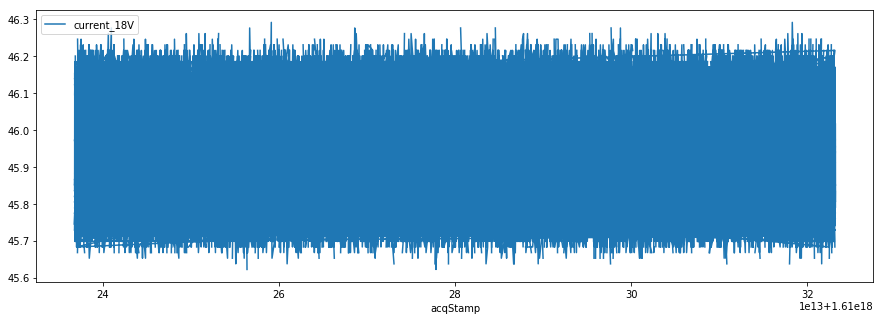

In [5]:
p_df = df1.select('acqStamp','current_18V').toPandas()
p_df.plot('acqStamp','current_18V',figsize=(15,5))
#p_df.sort_values(by='acqStamp').plot(pd.to_datetime(p_df['acqStamp'],unit='ns'),'current_18V',figsize=(15,5))

### 2) Extract data using variable names

In [6]:
df2 = DataQuery.builder(spark).byVariables() \
    .system('CMW') \
    .startTime('2018-04-29 00:00:00.000').endTime('2018-04-30 00:00:00.000') \
    .variable('LTB.BCT60:INTENSITY') \
    .build()

In [7]:
df2.toPandas()[:10]

,nxcals_value,nxcals_entity_id,nxcals_timestamp,nxcals_variable_name
0,1846.24,52034,1524960170465000000,LTB.BCT60:INTENSITY
1,1579.96,52034,1524960421265000000,LTB.BCT60:INTENSITY
2,1813.40,52034,1524960602465000000,LTB.BCT60:INTENSITY
3,2382.25,52034,1524960924065000000,LTB.BCT60:INTENSITY
4,7478.39,52034,1524960931265000000,LTB.BCT60:INTENSITY
5,2388.88,52034,1524961032065000000,LTB.BCT60:INTENSITY
6,2383.04,52034,1524961047665000000,LTB.BCT60:INTENSITY
7,2404.83,52034,1524961060865000000,LTB.BCT60:INTENSITY
8,2400.61,52034,1524961938065000000,LTB.BCT60:INTENSITY
9,2390.86,52034,1524962168465000000,LTB.BCT60:INTENSITY


### 3) Extract data using key/value pairs.

In [8]:
df3 = DataQuery.builder(spark).byEntities().system('WINCCOA') \
    .startTime('2018-06-15 00:00:00.000').endTime('2018-06-17 00:00:00.000') \
    .entity().keyValue('variable_name', 'MB.C16L2:U_HDS_3') \
    .build()

In [10]:
df3.toPandas().to_csv('/eos/user/p/pkothuri/winccoa_hds.csv', index=False)